# VGGNet16 features extraction.

One of the key components to be able to create a GMVAE of the CXR14 dataset, is to be able to retrieve <br>
the VGGne16 features, just as how the paper. <br><br> "Deep Generative Classifiers for Thoracic Disease Diagnosis with Chest X-ray Images" has done. <br>
link: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6651749/

In [25]:
 #Import necessary modules
import os
import torch

import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
from dotenv import load_dotenv
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2
load_dotenv()

True

### Set the path to here

Make sure the setup the paths properly!

In [26]:
#Path to assign tests (copy path directly)
notebooks_path = os.getcwd() # OR MAYBE has to be set manually depending your computer

#Set the path to this working directory
os.chdir(notebooks_path)
print(os.getcwd())

import sys
#Append the path the src folder
sys.path.append(os.path.join(os.getcwd(), os.pardir, "src"))

/Users/abhishekkumar/Projects/cs231n/CS231N-Final-Proj/notebooks


### Import the necessary module for downloading

Note for this: EVERYTIME There is a change inside the download <br>
the changes inside the file would only be shown if the jupyter kernel is restarted. <br>


In [27]:
# Import the necessary modules
from utils import CXReader, DfReader

### Set the data path

In [28]:
# Create the data path
df_path = os.path.join(notebooks_path, os.pardir, "meta")

# If the environment is defined, prefer that over the local path
if "DATA_PATH" in os.environ:
    data_path = os.environ["DATA_PATH"]
data_path = data_path or os.path.join(df_path, "images")
print(f'df_path: {df_path}, \ndata_path: {data_path}')

df_path: /Users/abhishekkumar/Projects/cs231n/CS231N-Final-Proj/notebooks/../meta, 
data_path: /Users/abhishekkumar/Projects/cs231n/cxr14/images


### Get the dataframes of the data
First, lets obtain the dataframes for the data and check that all metadata <br>
information has been set up properly. <br>

In [32]:
#Create a dataframe compiler
df_compiler = DfReader()

#set the path and retrieve the dataframes
df_compiler.set_folder_path(df_path)

#Get the dataframe holder and names
dfs_holder, dfs_names = df_compiler.get_dfs()

100%|██████████| 3/3 [00:00<00:00, 42.08it/s]

The file: miccai2023_nih-cxr-lt_labels_train.csv has been retrieved
The file: miccai2023_nih-cxr-lt_labels_test.csv has been retrieved
The file: miccai2023_nih-cxr-lt_labels_val.csv has been retrieved


In [41]:
# Get the device if cuda or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Define a transformations for the VGGnet16 (requires a 224,224)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.CenterCrop((224, 224)),  # Center crop to 224x224
    transforms.ToTensor(),
])

#Create datasets and dataloaders
test_dataset = CXReader(data_path=data_path, dataframe=dfs_holder[0], transform=transform, device=device)
train_dataset = CXReader(data_path=data_path, dataframe=dfs_holder[1], transform=transform,device=device)
val_dataset = CXReader(data_path=data_path, dataframe=dfs_holder[2], transform=transform, device=device)

#Sampled images from train to see single shape
samp3_image, label3 = train_dataset[1]
print("Shape of a single image and its labels")
print(f"Image: {samp3_image.shape}, labels: {label3.shape}")

#With batch size of 16, and shuffle true, and num workers = 4
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,  num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,  num_workers=2)

#Iterate inside a batch
for idx, batch in enumerate(train_loader):
    print(f"batch number: {idx}")
    images, labels = batch
    print("Shape of batch of images and labels")
    print(f"Images: {images.shape}, labels: {labels.shape}")
    if idx == 5:
        print("It can iterate through all batches")
        break

Shape of a single image and its labels
Image: torch.Size([3, 224, 224]), labels: torch.Size([15])


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


batch number: 0
Shape of batch of images and labels
Images: torch.Size([16, 3, 224, 224]), labels: torch.Size([16, 15])
batch number: 1
Shape of batch of images and labels
Images: torch.Size([16, 3, 224, 224]), labels: torch.Size([16, 15])
batch number: 2
Shape of batch of images and labels
Images: torch.Size([16, 3, 224, 224]), labels: torch.Size([16, 15])
batch number: 3
Shape of batch of images and labels
Images: torch.Size([16, 3, 224, 224]), labels: torch.Size([16, 15])
batch number: 4
Shape of batch of images and labels
Images: torch.Size([16, 3, 224, 224]), labels: torch.Size([16, 15])
batch number: 5
Shape of batch of images and labels
Images: torch.Size([16, 3, 224, 224]), labels: torch.Size([16, 15])
It can iterate through all batches


### Print an image and see the output

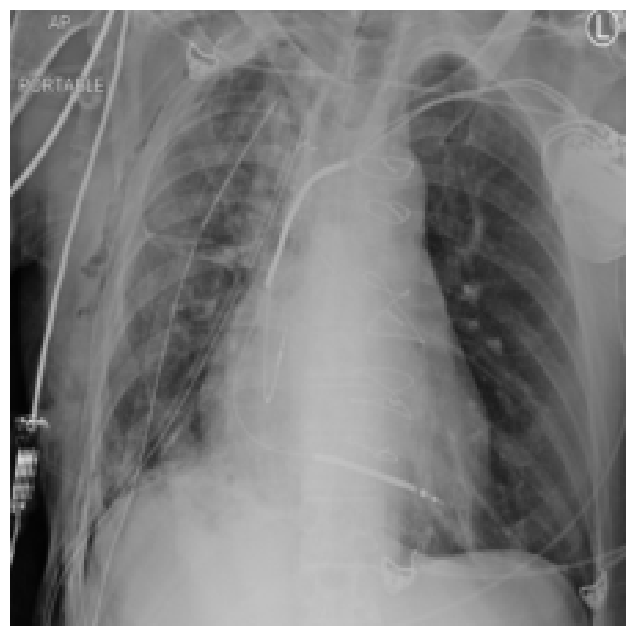

torch.Size([3, 224, 224])


In [40]:
from utils.plot import plot_image_no_normalisation

plot_image_no_normalisation(samp3_image)
print(samp3_image.shape)

### Obtain the vgg16_model features and set to eval

In [13]:
class VGGEncoder(torch.nn.Module):
    def __init__(self, pretrained=True):
        super(VGGEncoder, self).__init__()

        # Load pre-trained VGG16 model
        vgg16_model = models.vgg16(pretrained=pretrained)

        # Use only the features part and remove the classifier
        self.features = vgg16_model.features

        # Set to evaluation mode if not fine-tuning
        if not pretrained:
            self.features.eval()

    def forward(self, x):
        return self.features(x)

# Example usage
# For fine-tuning all features spaces from vgg16_model
#encoder_finetune = VGGEncoder(pretrained=False)
#encoder_finetune.train()

# For inference
encoder_inference = VGGEncoder(pretrained=True)
encoder_inference.eval()

#Print output and output features
output_features = encoder_inference(samp3_image)
print(output_features)
print(output_features.shape)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0370, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.5853, 1.1749,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.2216, 0.8938,  ..., 0.1804, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.8993, 0.7857, 0.6817,  ..., 0.3933, 0.7594, 1.0564],
         [0.0000, 0.3005, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.3355, 0.3787,  ..., 0.0000, 0.0000, 0.

### Now that we have seen the VGG16 layer.
Lets implement the solution where we flat the feature vector to a 1x1xD vector. <br>
just as how the paper does it.

In [14]:
class TransitionLayer(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(TransitionLayer, self).__init__()
        
        # Convolutional layer with kernel size 1x1
        self.conv1x1 = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        
        # Batch normalization
        self.batch_norm = nn.BatchNorm2d(output_channels)
        
        # ReLU activation
        self.relu = nn.ReLU(inplace=True)
        
        # Max pooling with kernel size equal to the feature map size
        self.max_pool = nn.MaxPool2d(kernel_size=7)

    def forward(self, x):
        # Apply operations sequentially
        x = self.conv1x1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.max_pool(x)
        return x

# Example usage
input_channels = 512
output_channels = 300 # D is the desired number of channels
transition_layer = TransitionLayer(input_channels, output_channels)

# Assuming input_tensor is of size (batch_size, 512, 7, 7)
input_tensor = torch.randn(3, 512, 7, 7)

# Apply the transition layer
output = transition_layer(input_tensor)

# Print the shape of the final feature vector
print(output.shape)
print(output)

torch.Size([3, 300, 1, 1])
tensor([[[[2.9033]],

         [[1.9729]],

         [[2.6344]],

         [[2.1812]],

         [[1.8654]],

         [[1.6665]],

         [[1.6841]],

         [[2.8485]],

         [[1.9693]],

         [[1.9428]],

         [[1.9075]],

         [[2.2622]],

         [[2.4120]],

         [[3.1667]],

         [[2.6403]],

         [[2.6508]],

         [[1.8631]],

         [[3.6698]],

         [[1.8254]],

         [[2.6148]],

         [[2.9299]],

         [[1.8592]],

         [[2.3962]],

         [[2.4487]],

         [[2.2068]],

         [[2.4195]],

         [[2.2245]],

         [[1.9411]],

         [[2.2651]],

         [[1.8397]],

         [[2.1052]],

         [[2.2936]],

         [[2.3748]],

         [[3.1480]],

         [[1.6557]],

         [[2.6824]],

         [[2.5306]],

         [[0.9486]],

         [[2.3012]],

         [[2.8174]],

         [[1.8243]],

         [[3.5568]],

         [[2.0093]],

         [[2.7931]],

     

# BIIIIG. We know the feature space at the end would be 512, 7, 7. 
This means that, if we want to create an encoder that would take this; and convert it to a sampling gaussian representation <br>
we need to do the following:
1. Pass a VGGnet16 pretrained features at eval mode (option to pretrain it too) to 512, 7, 7.
2. Pass that VGGnet16 through a transition layer that would flat it to a num_channelsx 300 output (3 since RGB).
3. Use this to sample a mean and gaussian distribution uing homework codes to retrieve results.

### Create a function that would sample gaussian parameters.
Use functions from hw2 utils.py to do this.

In [15]:
from torch.nn import functional as F
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    print(f"h dimension passed through gaussian paremeters i {h.shape}")
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v

### Create the Encoder
Now that we have replcated all of the transformations required to perform the encoder first time .<br>

In [16]:
class Encoder(torch.nn.Module):
    def __init__(self,  z_dim, y_dim=0, pretrained=True,):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        # Load pre-trained VGG16 model
        vgg16_model = models.vgg16(weights=pretrained)

        # Use only the features part and remove the classifier
        self.features = vgg16_model.features

        # Set to evaluation mode if not fine-tuning
        if not pretrained:
            self.features.eval()
        
        # Convolutional layer with kernel size 1x1
        self.conv1x1 = nn.Conv2d(512, 300, kernel_size=1)
        
        # Batch normalization
        self.batch_norm = nn.BatchNorm2d(300)
        
        # ReLU activation
        self.relu = nn.ReLU(inplace=True)
        
        # Max pooling with kernel size equal to the feature map size
        self.max_pool = nn.MaxPool2d(kernel_size=7)

        #Obtain the net
        self.net = nn.Sequential(
            nn.Linear(300, 2 * z_dim),
        )

    def forward(self, x):
        # Create feature map from vgget16
        feat_map = self.features(x)

        # Apply operations to obtain transition layer from paper
        h = self.conv1x1(feat_map)
        h = self.batch_norm(h)
        h = self.relu(h)
        h = self.max_pool(h)

        # Convert output from 3, 300, 1, 1 to 3, 300
        h = h.view(h.shape[0], h.shape[1])

        #Now pass it through the net to obtain gaussian space
        g = self.net(h)

        #Pass the feature space and get gaussian parameters
        m, v = gaussian_parameters(g, dim=1)
        return m, v
    
#Sampled images from train to see single shape
samp3_image, label3 = train_dataset[1]
print("Shape of a single image and its labels")
print(f"Image: {samp3_image.shape}, labels: {label3.shape}")

#Create encoder compiler
encoder_compiler = Encoder(z_dim = 2)

#Iterate inside a batch
for idx, batch in enumerate(test_loader):
    print(f"batch number: {idx}")
    images, labels = batch
    print("Shape of batch of images and labels")
    print(f"Images: {images.shape}, labels: {labels.shape}")
    output = encoder_compiler(images)
    if idx == 5:
        print("It can iterate through all batches")
        break

print(output[0].shape)
print(output[1].shape)

Shape of a single image and its labels
Image: torch.Size([3, 224, 224]), labels: torch.Size([20])
batch number: 0
Shape of batch of images and labels
Images: torch.Size([16, 3, 224, 224]), labels: torch.Size([16, 20])
h dimension passed through gaussian paremeters i torch.Size([16, 4])
batch number: 1
Shape of batch of images and labels
Images: torch.Size([16, 3, 224, 224]), labels: torch.Size([16, 20])
h dimension passed through gaussian paremeters i torch.Size([16, 4])
batch number: 2
Shape of batch of images and labels
Images: torch.Size([16, 3, 224, 224]), labels: torch.Size([16, 20])
h dimension passed through gaussian paremeters i torch.Size([16, 4])
batch number: 3
Shape of batch of images and labels
Images: torch.Size([16, 3, 224, 224]), labels: torch.Size([16, 20])
h dimension passed through gaussian paremeters i torch.Size([16, 4])
batch number: 4
Shape of batch of images and labels
Images: torch.Size([16, 3, 224, 224]), labels: torch.Size([16, 20])
h dimension passed through